In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [2]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

## Full Dataset

In [ ]:
protocols = np.array([59, 60, 82, 88, 89, 90, 95, 110, 123, 140, 156, 168, 180, 186, 201, 203, 208, 212, 225, 226, 241, 248])

In [ ]:
# We need to read data and transform the time column into datetime object
files = ['<sensor_id>']

data = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"../data/tpms-{f}.csv")
    df["time"] = pd.to_datetime(df["time"])
    df.set_index(["time"], inplace=True)
    df = df[df["protocol"].isin(protocols)]
    if data.empty:
        data = df
    else:
        data = pd.concat((data,df))

In [ ]:
cars = pd.read_csv('../data/cars.csv')
cars_np = cars[['id1','id2','id3','id4','id5','id6','id7','id8']].to_numpy(dtype=str).flatten()
cars_np = cars_np[~(cars_np == 'nan')]

In [ ]:
# # Threshold for minimum number of occurrences
# threshold = 1  # Adjust this number as needed

# # Group by 'id' and count occurrences
# id_counts = data.groupby("id").size().sort_values(ascending=False)

# # Filter IDs by the threshold
# filtered_ids = id_counts[id_counts >= threshold].index

# Filter the original DataFrame to keep only rows with these IDs
filtered = data[data["id"].isin(cars_np)].drop(["Unnamed: 0"], axis=1)
filtered.shape

## Filtered

In [67]:
files = 5
filtered = pd.read_csv(f'../share/tpms-merged-{files}.csv')
cars = pd.read_csv('../data/cars.csv')
cars_np = cars[['id1','id2','id3','id4']].to_numpy(dtype=str).flatten()
cars_np = cars_np[~(cars_np == 'nan')]
filtered.index = pd.to_datetime(filtered['time'])
filtered.shape

(56836, 17)

In [6]:
grouping_analysis = [['30S','30 sec.'],['1T','1 min.'],['2T','2 min.'],['5T','5 min.'], ['10T','10 min.'], ['1H','1 h.'], ['2H','2 h.'], ['5H','5 h.']]

In [61]:
selector = 0
grouping_time = grouping_analysis[selector][0]

# Group by time bins and 'id', and count occurrences
grouped = filtered.groupby([pd.Grouper(freq=grouping_time), 'id']).size().reset_index(name='count')

# Create pivot table
pivot_table = grouped.pivot_table(index='time', columns='id', values='count', fill_value=0)

# Compute correlation matrix
correlation_matrix = pivot_table.corr()

cmin,cmax = np.min(correlation_matrix), np.max(correlation_matrix)
correlation_matrix = (correlation_matrix - cmin) / (cmax - cmin)

In [62]:
corr_mat = np.zeros((pivot_table.shape[1],pivot_table.shape[1]))

In [63]:
pivot_sum = pivot_table
for i in range(len(cars_np)):
    c1 = pivot_sum.loc[:,cars_np[i]].to_numpy()
    m1 = np.max(scipy.signal.correlate(c1,c1))
    for j in range(i,len(cars_np)):
        c2 = pivot_sum.loc[:,cars_np[j]].to_numpy()
        m2 = np.max(scipy.signal.correlate(c2,c2))
        la = scipy.signal.correlation_lags(len(c1),len(c2))
        xc = scipy.signal.correlate(c1,c2)

        l0 = np.where(la == 0)[0]
        corr_mat[i,j] = np.abs(xc[l0][0]) / np.max([m1,m2])

i_lower = np.tril_indices(corr_mat.shape[0], -1)
corr_mat[i_lower] = corr_mat.T[i_lower]

corr_mat_db = 10*np.log10(corr_mat+1e-6)
corr_mat_db[corr_mat_db < -30] = -30

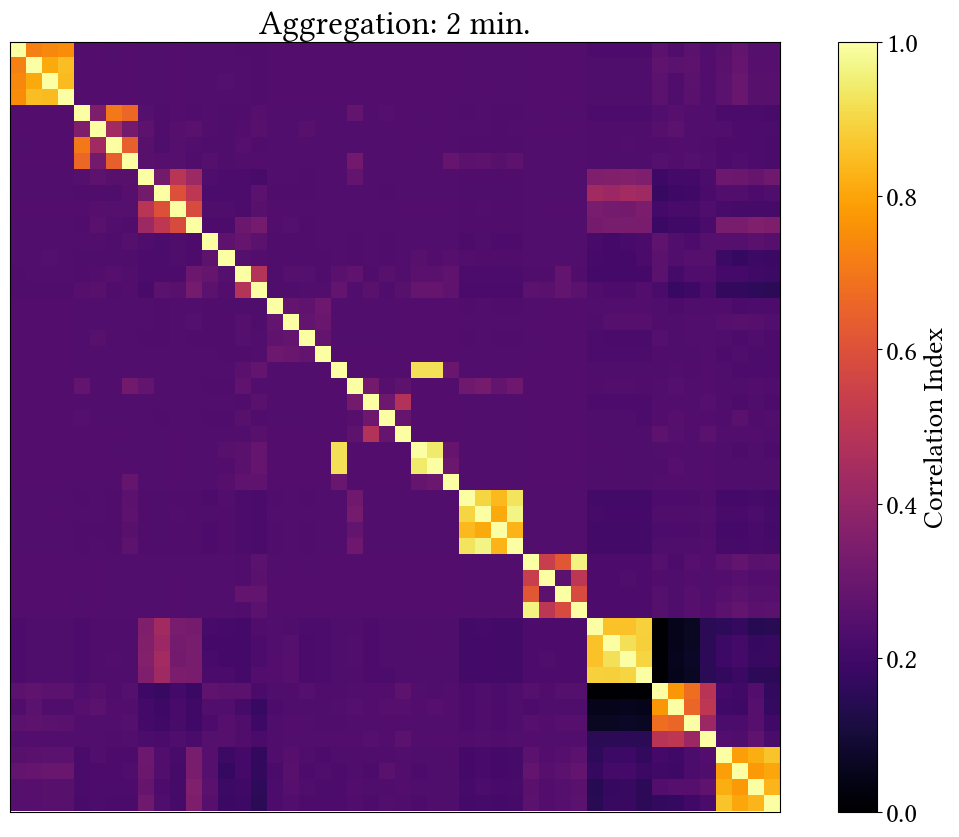

In [55]:
f, ax = plt.subplots(figsize=(15, 10))

im = ax.imshow(correlation_matrix, cmap='inferno')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'Aggregation: {grouping_analysis[selector][1]}')

cbar = f.colorbar(im, ax=ax)
cbar.set_label('Correlation Index')

# plt.savefig(f'../pics/correlation_{grouping_analysis[selector][0]}_n{len(files)}.pdf', format='pdf', bbox_inches='tight')
plt.show()